In [2]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import mlp
import importlib
from sklearn.model_selection import train_test_split
import sklearn
from matplotlib import pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
x_train = np.loadtxt('preprocessed/x_train.csv', delimiter=',')
y_train = np.loadtxt('preprocessed/y_train.csv', delimiter=',')
x_test = np.loadtxt('preprocessed/x_test.csv', delimiter=',')
y_test = np.loadtxt('preprocessed/y_test.csv', delimiter=',')

In [5]:
x_train = torch.from_numpy(x_train).float().cuda()
y_train = torch.from_numpy(y_train).float().cuda().unsqueeze(1)
x_test = torch.from_numpy(x_test).float().cuda()
y_test = torch.from_numpy(y_test).float().cuda().unsqueeze(1)

In [6]:
size_feature = x_train.shape[1]
size_train = x_train.shape[0]
size_test = x_test.shape[0]
print(f'feature size: {size_feature} | train size: {size_train} | test size: {size_test}')

feature size: 44 | train size: 135440 | test size: 33860


In [21]:
batch_size = 1024
num_epoch = 1000
lr = 0.001

In [22]:
loader_train = DataLoader(list(zip(x_train, y_train)), shuffle=True, batch_size=batch_size)

In [23]:
model = mlp.MLP(size_feature, 1, [256, 256, 256, 256], device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()

In [24]:
model.train()
loss_record = []
for epoch in range(num_epoch):
    num_correct = 0
    for i, (x, y) in enumerate(loader_train):
        x, y = x.to(device), y.to(device)
        yhat = model(x)
        loss = criterion(yhat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        num_correct += (torch.round(torch.sigmoid(yhat.detach())) == y).sum() 
    accuracy = num_correct / float(size_train)
    print(f'[Info] epoch: {epoch + 1}/{num_epoch} | loss: {loss} | accuracy: {accuracy}')

[Info] epoch: 1/1000 | loss: 0.40970858931541443 | accuracy: 0.7504060864448547
[Info] epoch: 2/1000 | loss: 0.45355814695358276 | accuracy: 0.7957324385643005
[Info] epoch: 3/1000 | loss: 0.3758341073989868 | accuracy: 0.8031747937202454
[Info] epoch: 4/1000 | loss: 0.3901333212852478 | accuracy: 0.8091257810592651
[Info] epoch: 5/1000 | loss: 0.4468590021133423 | accuracy: 0.8127214908599854
[Info] epoch: 6/1000 | loss: 0.41020551323890686 | accuracy: 0.8155567049980164
[Info] epoch: 7/1000 | loss: 0.4511565566062927 | accuracy: 0.8183697462081909
[Info] epoch: 8/1000 | loss: 0.34565550088882446 | accuracy: 0.8221721649169922
[Info] epoch: 9/1000 | loss: 0.43356773257255554 | accuracy: 0.8240401744842529
[Info] epoch: 10/1000 | loss: 0.3946516215801239 | accuracy: 0.8275693655014038
[Info] epoch: 11/1000 | loss: 0.3773539066314697 | accuracy: 0.8290017247200012
[Info] epoch: 12/1000 | loss: 0.40634214878082275 | accuracy: 0.831748366355896
[Info] epoch: 13/1000 | loss: 0.356966257095

In [25]:
model.eval()
yhat_test = torch.round(torch.sigmoid(model(x_test)))
yhat_test_ = yhat_test.detach().cpu().numpy()
y_test_ = y_test.cpu().numpy()
print(sklearn.metrics.classification_report(y_test_, yhat_test_))

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.88     16863
         1.0       0.91      0.85      0.88     16997

    accuracy                           0.88     33860
   macro avg       0.88      0.88      0.88     33860
weighted avg       0.88      0.88      0.88     33860



In [26]:
print(sklearn.metrics.roc_auc_score(y_test_, yhat_test_))

0.8807633242839777


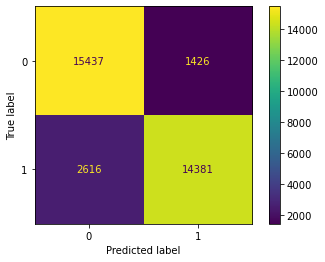

In [27]:
cm = sklearn.metrics.confusion_matrix(y_test_, yhat_test_)
cm_disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()
